In [1]:
import sys

import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import time

In [2]:
class Law:
    """Underlying law which needs to be fitted, the underlying law with be the
    `N_coefficients - 1` Chebyshev polynomial
    """
    def __init__(self, N_law):
        chev_c = np.zeros(N_law); chev_c[-1] = 1
        c_ = np.polynomial.chebyshev.cheb2poly(chev_c)
        self.c = np.asarray(c_)
        
class Data(Law):
    """Set of finite data points, generated from the underlying law"""
    def __init__(self, N_law, N_x, x_i, x_f, noise_level, sigma, N_replicas):
        super().__init__(N_law)
        self.x = (x_f - x_i)*np.random.rand(N_x) + x_i
        #self.true = np.polyval(self.c[::-1], self.x)
        self.eta = (noise_level > 0)*sigma*np.random.randn(N_x)
        self.delta = (noise_level > 1)*sigma*np.random.randn(N_replicas, N_x)
        self.y = np.polyval(self.c[::-1], self.x) + self.eta + self.delta
        self.sigma = sigma
        
class Model:
    """Polynomial model to fit the underlying law. Coefficients which correspond to an analytic fit
    of the data are generated upon initialization. Coefficients obtained from a numerical fit are
    generated with the `Numericfit` method
    """
    def __init__(self, N_model, data):
        ho_c = np.zeros(data.c.shape[0])
        ho_c[min([data.c.shape[0], N_model]):] = data.c[min([data.c.shape[0], N_model]):]
        v = np.zeros((data.delta.shape[0], N_model, 1))
        A_inv = np.zeros((data.delta.shape[0], N_model, N_model))
        for i in range(N_model):
            v[:, i] = ((data.eta + data.delta + np.polyval(ho_c[::-1], data.x))*(
                        data.x**(i))).mean(axis=1)[:, np.newaxis]
            for j in range(N_model):
                A_inv[:, i, j] = (data.x**(i+j)).mean()
        A = np.linalg.inv(A_inv)
        c_rep = np.zeros(N_model)
        c_rep[:min([data.c.shape[0], N_model])] = data.c[:min([data.c.shape[0], N_model])]
        self.GA = np.matmul(A, v) + c_rep[np.newaxis,:, np.newaxis]
        self.GN = np.zeros((data.delta.shape[0], N_model))
        self.sigma = data.sigma
    
    def Numericfitext1(self, data, N_steps, lr):
        np.random.seed(1234)
        index_range = np.arange(data.x.shape[0])
        shuffle_index = np.zeros(data.y.shape, dtype=int)
        y_data = np.zeros(data.y.shape)
        for i in range(shuffle_index.shape[0]):
            np.random.shuffle(index_range)
            shuffle_index[i, :] = index_range
            y_data[i, :] = data.y[i, index_range]
        x = data.x[shuffle_index]
        #gamma = np.random.rand(*self.GN.shape)*(np.max(self.GA, axis=0)[:,0] - np.min(self.GA, axis=0)[:,0]
        #                                      ) + np.min(self.GA, axis=0)[:,0]
        gamma = np.random.rand(*self.GN.shape)
        #print(gamma.shape)
        gamma_hist = np.random.rand(*self.GN.shape, N_steps)
        #print(gamma_hist.shape)
        grad_chi2 = np.zeros(gamma.shape)
        tv_split = int(x.shape[1]/2)
        chi2_valid = np.zeros((x.shape[0], N_steps))
        for k in range(N_steps):
            y_fit = Generate_y(x[:, :tv_split], gamma)
            for i in range(grad_chi2.shape[1]):
                grad_chi2[:, i] = np.sum((2*(x[:, :tv_split]**(i))*(y_fit - y_data[:, :tv_split])
                                         )/(data.sigma**2), axis=1)
            gamma -= lr*grad_chi2
            gamma_hist[:, :, k] = gamma
            y_valid = Generate_y(x[:, tv_split:], gamma)
            chi2_valid[:, k] = np.sum(((y_valid - y_data[:, tv_split:])**2)/(data.sigma**2), axis=1)
            #if k % 100 == 0: sys.stdout.write('\rStep {0}'.format(k))
        lookback = np.argmin(chi2_valid, axis=1)
        #print(gamma_hist[np.arange(gamma_hist.shape[0]), :, lookback].shape)
        self.GN = gamma_hist[np.arange(gamma_hist.shape[0]), :, lookback]
    
    def Numericfitext(self, data, N_steps, lr):
        np.random.seed(1234)
        index_range = np.arange(data.x.shape[0])
        shuffle_index = np.zeros(data.y.shape, dtype=int)
        y_data = np.zeros(data.y.shape)
        for i in range(shuffle_index.shape[0]):
            np.random.shuffle(index_range)
            shuffle_index[i, :] = index_range
            y_data[i, :] = data.y[i, index_range]
        x = data.x[shuffle_index]
        #gamma = np.random.rand(*self.GN.shape)*(np.max(self.GA, axis=0)[:,0] - np.min(self.GA, axis=0)[:,0]
        #                                      ) + np.min(self.GA, axis=0)[:,0]
        gamma = np.random.rand(*self.GN.shape)
        gamma = Gradientdecent(N_steps, gamma, y_data, x, lr, data.sigma)
        self.GN = gamma
        
    def Numericfit(self, data, N_steps, lr, shuffle):
        np.random.seed(1234)
        index_range = np.arange(data.x.shape[0])
        shuffle_index = np.zeros(data.y.shape, dtype=int)
        y_data = np.zeros(data.y.shape)
        tv_split = int(y_data.shape[1]/2)
        if shuffle == True:
            for i in range(shuffle_index.shape[0]):
                np.random.shuffle(index_range)
                shuffle_index[i, :] = index_range
                y_data[i, :] = data.y[i, index_range]
            x = data.x[shuffle_index]
        else:
            for i in range(shuffle_index.shape[0]):
                shuffle_index[i, :] = index_range
                y_data[i, :] = data.y[i, index_range]
            x = data.x[shuffle_index]
        #gamma = np.random.rand(*self.GN.shape)*(np.max(self.GA, axis=0)[:,0] - np.min(self.GA, axis=0)[:,0]
        #                                      ) + np.min(self.GA, axis=0)[:,0]
        gamma = np.random.rand(*self.GN.shape)
        gamma_hist, chi2_valid = Gradientdecent2(N_steps,x[:, :tv_split],x[:, tv_split:],y_data[:, :tv_split],
                                                 y_data[:, tv_split:],lr,data.sigma,gamma)
        lookback = np.argmin(chi2_valid, axis=1)
        self.GN = gamma_hist[np.arange(gamma_hist.shape[0], dtype=int), :, lookback]

@jit('f8(f8[:, :], f8[:, :])')
def Generate_y(x, coefficients):
    y = np.zeros((x.shape))
    for i in range(coefficients.shape[1]):
        y += coefficients[:, i, np.newaxis]*(x**i)
    return y
        
def Plotsmoothpoly(coeff):
    """interpolates set of coefficients and plots"""
    x = np.linspace(-2, 2, 100)
    y = np.zeros((x.shape[0], coeff.shape[0]))
    for i in range(coeff.shape[0]):
        y[:, i] = np.polyval(coeff[i, ::-1], x)
    plt.plot(x, y, '-')
    plt.ylim(-2, 2)
    plt.xlim(-2, 2)
    plt.show()

def Plotdata(x, y):
    """very simple plot of data points"""
    plt.plot(x, y.T, '*')

@jit('f8(i8, f8[:, :], f8[:, :], f8[:, :], f8, f8)')
def Gradientdecent(N_steps, gamma_initial, y_data, x, lr, sigma):
    gamma = gamma_initial
    grad_chi2 = np.zeros(gamma.shape, dtype='f8')
    tv_split = int(y_data.shape[1]/2)
    chi2_valid = np.zeros((y_data.shape[0], N_steps))
    #print(y_data.shape[0])
    gamma_hist = np.zeros((gamma.shape[0], gamma.shape[1], N_steps))
    #print(gamma_hist.shape)
    for k in range(N_steps):
        y_fit = Generate_y(x[:, :tv_split], gamma)
        for i in range(grad_chi2.shape[1]):
            grad_chi2[:, i] = np.sum((2*(x[:, :tv_split]**(i))*(y_fit - y_data[:, :tv_split])
                                        )/(sigma**2), axis=1)
        gamma -= lr*grad_chi2
        gamma_hist[:, :, k] = gamma
        y_valid = Generate_y(x[:, tv_split:], gamma)
        chi2_valid[:, k] = np.sum(((y_valid - y_data[:, tv_split:])**2)/(sigma**2), axis=1)
            #if k % 100 == 0: sys.stdout.write('\rStep {0}'.format(k))
    lookback = np.argmin(chi2_valid, axis=1)
    return gamma_hist[np.arange(gamma_hist.shape[0], dtype=int), :, lookback]

@jit(nopython=True)
def Gradientdecent2(N_steps,x_train,x_valid,y_train,y_datavalid,lr,sigma,gamma_initial):
    gamma = gamma_initial
    grad_chi2 = np.zeros(gamma.shape)
    chi2_valid = np.zeros((y_datavalid.shape[0], N_steps))
    gamma_hist = np.zeros((gamma.shape[0], gamma.shape[1], N_steps))
    for k in range(N_steps):
        y_fit = np.zeros((x_train.shape))
        for i in range(gamma.shape[1]):
            for j in range(gamma.shape[0]):
                y_fit[j, :] += gamma[j, i]*(x_train[j, :]**i)
        for i in range(grad_chi2.shape[1]):
            grad_chi2[:, i] = np.sum((2*(x_train**(i))*(y_fit - y_train)
                                        )/(sigma**2), axis=1)
        gamma -= lr*grad_chi2
        gamma_hist[:, :, k] = gamma
        y_valid = np.zeros((x_train.shape))
        for i in range(gamma.shape[1]):
            for j in range(gamma.shape[0]):
                y_valid[j, :] += gamma[j, i]*(x_valid[j, :]**i)
        chi2_valid[:, k] = np.sum(((y_valid - y_datavalid)**2)/(sigma**2), axis=1)
            #if k % 100 == 0: sys.stdout.write('\rStep {0}'.format(k))
    return gamma_hist, chi2_valid
        

## Implementing Bias-Variance Decomposition

### "Case 1": Bias-Variance Decomposition

(Andre) Here we will implement the bias-variance decomposition of the chi-square error:

$\mathbb{E}_{\mathcal{L}, \delta} \left[ X^2 \right] = 1 +
\sum_{i=1}^{n} \frac{1}{n \sigma_i^2}(f(x_i) - \mathbb{E}_{\mathcal{L}}\left[ g_{\mathcal{L}}(x_i) \right])^2
+ \sum_{i=1}^{n} \frac{1}{n \sigma_i^2} \mathbb{E}_{\mathcal{L}} \left[ (g_{\mathcal{L}}(x_i) - \mathbb{E}_{\mathcal{L}} \left[ g_{\mathcal{L}} (x_i) \right])^2 \right] 
+ 2 \sum_{i=1}^{n} \frac{1}{n \sigma_i^2} (f(x_i) - \mathbb{E}_{\mathcal{L}} \left[ g_{\mathcal{L}} (x_i) \right]) \eta_i$

We refer to the first term ($1$) as the _level-2 noise_, the second term as the _bias_, the third term as the _variance_ and the last term as the _level-1 noise_. In this case the value of $\sigma$ is constant for all points and so is taken out of the sum as a constant.

The first case that will be tested will be that in which the different data sets used to train the models are differentiated by changing the y-values and keeping the x-values unshuffled. That is we will be using data sets $\mathcal{L} = \{ (y_i^{(l)}, x_i) \}$ where $y_i^{(l)} = f(x_i) + \delta_l$ are different only in the value of the second level noise.

Analytically we can make some predictions in this case: (see appendix for proofs)

First we note that the _variance_ will be (in the limit of infinite training sets) equal to $\frac{1}{n}\mathrm{Tr}(Z_{\mathcal{L}}^T X^T X Z_{\mathcal{L}})$ where where $X$ is the design matrix of data used to evaluate chi-squared and $ Z_{\mathcal{L}} = (X_{\mathcal{L}}^T X_{\mathcal{L}})^{-1} X_{\mathcal{L}}^T$ where $X_{\mathcal{L}}$ is the design matrix of data used to train the model. 

In the special case where $X_{\mathcal{L}} = X$ we get $Var = \frac{p}{n}$ where $p$ is the order of the model polynomial and $n$ the number of data points used to train the model. Here we see explicitly how the variance increases with model complexity ($p$) and decreases with the amount of data used in training ($n$).

Secondly we have the the _bias_ will be (in the limit of infinite training sets) given by $Bias^2 = \frac{1}{n \sigma^2}(\mathbf{y}_0^T\mathbf{y}_0 - \mathbf{y}_{0, \mathcal{L}}^T Z_{\mathcal{L}}^T X^T \mathbf{y}_0 - \mathbf{y}_0^T X Z_{\mathcal{L}} \mathbf{y}_{0, \mathcal{L}} - \mathbf{y}_{0, \mathcal{L}}^T Z_{\mathcal{L}}^T X^T X Z_{\mathcal{L}} \mathbf{y}_{0, \mathcal{L}})$. 

In the special case where the data used to train the models is the same as the data used to evaluate the chi-squared we have that $ Bias^2 = \frac{1}{n \sigma^2} \mathbf{y}_0^T(I - H)\mathbf{y}_0.$

In [3]:
# functions for computing bias, variance given model data, true data, "measured" data and 
# variance (sigma) of the generator.
def bias(y_data_model, y_data_true, sigma):
    avg_model_data = np.sum(y_data_model, 0)/len(y_data_model[:, 0])
    return(np.dot(avg_model_data-y_data_true, avg_model_data-y_data_true)/(sigma**2*len(y_data_model[0])))
    
def variance(y_data_model, sigma):
    avg_model_data = np.sum(y_data_model, 0)/len(y_data_model[:, 0])
    avg_model_data_sqrd = np.sum(y_data_model**2, 0)/len(y_data_model[:, 0])
    return(sum(avg_model_data_sqrd - avg_model_data**2)/(sigma**2*len(y_data_model[0])))
    

In [4]:
# function to compute the average chi-squared of of a group of replicas
def chi_2(coef_model, data):
    N_rep = len(coef_model[:,1])
    # evaluate the replicas on data set data
    y_data_model = np.zeros((N_rep, len(data.x)))
    
    for i in range(0, N_rep):
        for j in range(0, len(coef_model[1])):
            y_data_model[i] += coef_model[i][j]*data.x**j
            
    return(sum(np.sum((data.y - y_data_model)**2, 0)/(data.sigma**2*len(data.x)))/N_rep)

In [5]:
# function to compute the bias and variance of a set of replicas on a 
# set x_0
def gen_bias_and_variance(coef_model, law, data_eval):
    # define explicitly for clarity
    N_rep = len(coef_model[:,1])
    # obtain the coefficients of underlying law
    coef_law = law.c
    # evaluate the replicas and the true model on data set x_0
    y_data_model = np.zeros((N_rep, len(data_eval.x)))
    
    for i in range(0, N_rep):
        for j in range(0, len(coef_model[1])):
            y_data_model[i] += coef_model[i][j]*data_eval.x**j
    
    #evaluate the true model on data set x_0
    y_data_law = np.zeros(len(data_eval.x))
    for j in range(len(coef_law)):
        y_data_law += coef_law[j]*data_eval.x**j
    
    bias_model = bias(y_data_model, y_data_law, data_eval.sigma)
    variance_model = variance(y_data_model, data_eval.sigma)
    return (bias_model, variance_model)

In [6]:
# functions to compute the level-1 and level-2 noise (if we don't perform averaging over level-2 noise) contributions
def noise_lv1(coef_model, law, data):
    # define explicitly for clarity
    N_rep = len(coef_model[:,1])
    # obtain the coefficients of underlying law
    coef_law = law.c
    # evaluate the replicas and the true model on data set x_0
    y_data_model = np.zeros((N_rep, len(data.x)))
    
    for i in range(0, N_rep):
        for j in range(0, len(coef_model[1])):
            y_data_model[i] += coef_model[i][j]*data.x**j
    
    #evaluate the true model on data set x_0
    y_data_law = np.zeros(len(data.x))
    for j in range(len(coef_law)):
        y_data_law += coef_law[j]*data.x**j
    N_rep = len(coef_model[:,1])
    
    # compute the average model data
    avg_model_data = np.sum(y_data_model, 0)/len(y_data_model[:,0])

    return(2*sum(np.multiply(data.eta,(y_data_law-avg_model_data)))/(data.sigma**2*len(y_data_law)) + sum(data.eta**2)/(data.sigma**2*len(y_data_law)))

def noise_lv2(coef_model, law, data):
    """WIP (gives very large answers, I think there is an issue with the code, not the predictions)"""
    N_rep = len(coef_model[:,1])
    # obtain the coefficients of underlying law
    coef_law = law.c
    # evaluate the replicas and the true model on data set x_0
    y_data_model_with_noise = np.zeros((N_rep, len(data.x)))
    
    for i in range(0, N_rep):
        for j in range(0, len(coef_model[1])):
            y_data_model_with_noise[i] += np.multiply((coef_model[i][j]*data.x**j), data.delta[i])
    
    #evaluate the true model on data set x_0
    y_data_law = np.zeros(len(data.x))
    for j in range(len(coef_law)):
        y_data_law += coef_law[j]*data.x**j
    N_rep = len(coef_model[:,1])
    
    # compute the average model data
    avg_model_data_with_noise = np.sum(y_data_model_with_noise, 0)/len(y_data_model_with_noise[:,0])
    avg_noise = np.sum(data.sigma, 0)
    
    return(2*sum((np.multiply(y_data_law, avg_noise)-avg_model_data_with_noise)/(data.sigma**2*len(y_data_law))))
    

Here we test the computations of bias and variance. We compute the limiting value of variance and the bias expressed above and compare the results to see how well they agree.

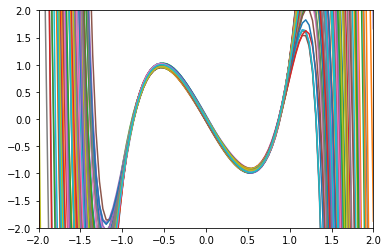

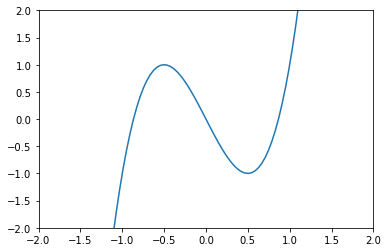

Bias and Variance: 0.0599499434835, 11.7982851867
Level 1 Noise: 0.957431487366
Level 2 Noise: 41.0001016342
BVD sum: 13.8156666176
Analytic values: 5.68434188608e-13, 104.205794168
Chi Square: 13.8613400165


In [7]:
N_law = 4
x_i = -1
x_f = 1
N_x=200
sigma = 0.1
noise_level = 2
N_model = 10

#define bounds to evaluate chi-squared
x_i_chi = 1
x_f_chi = 1.2
N_eval = 100

# determine the underlying law and data set data_eval to evaluate the chi-squared on
law_case_1 = Law(N_law)
N_replicas = 100
data_eval = Data(N_law, N_eval, x_i_chi, x_f_chi, noise_level, sigma, N_replicas)

# compute the bias and variance numerically using the analytical coefficients
data_case_1 = Data(N_law, N_x, x_i, x_f, noise_level, sigma, N_replicas)
model_case_1 = Model(N_model, data=data_case_1)
model_case_1.Numericfit(data_case_1, 4000, 0.00001, False)
coef_model = model_case_1.GN
#coef_model = model_case_1.GA
bias_1, variance_1 = gen_bias_and_variance(coef_model, law_case_1, data_eval)
chi_square = chi_2(coef_model, data_eval)
level_1_noise = noise_lv1(coef_model, law_case_1, data_eval)
level_2_noise = noise_lv2(coef_model, law_case_1, data_eval)

# compute the analytical prediction for the bias
X = np.zeros((N_eval, N_model))
X_l = np.zeros((N_x, N_model))
for i in range(N_model):
    X[:,i] = data_eval.x**i
    X_l[:,i] = data_case_1.x**i
y_0 = np.zeros((N_eval))
y_l = np.zeros((N_x))
for i in range(N_law):
    y_0 += law_case_1.c[i]*data_eval.x**i
    y_l += law_case_1.c[i]*data_case_1.x**i
Z_l = np.dot(np.linalg.inv(np.dot(np.transpose(X_l), X_l)),np.transpose(X_l))
analytic_bias = (np.dot(y_0, y_0))- np.dot(y_l, np.dot(np.transpose(Z_l), np.dot(np.transpose(X), y_0)))- \
                          np.dot(y_0, np.dot(X, np.dot(Z_l, y_l))) +\
                          np.dot(y_l, np.dot(np.transpose(Z_l), np.dot(np.transpose(X), np.dot(X, np.dot(Z_l, y_l)))))\
                          /(N_eval*sigma**2)
analytic_variance= np.trace(np.dot(np.transpose(Z_l),np.dot(np.transpose(X),np.dot(X, Z_l))))/(N_eval)

Plotsmoothpoly(coef_model)
Plotsmoothpoly(np.array([law_case_1.c]))

print("Bias and Variance: " + str(bias_1) + ", "+ str(variance_1))
print("Level 1 Noise: " + str(level_1_noise))
print("Level 2 Noise: " + str(level_2_noise))
print("BVD sum: " + str(1 + bias_1 + variance_1 + level_1_noise))
print("Analytic values: " + str(analytic_bias) + ", " + str(analytic_variance))
print("Chi Square: " + str(chi_square))

### "Case 2": Bias-Variance Decomposition

In this case the data that we will use to train the models on will be given by the sets $\mathcal{L} = \{(y_i, x_i^{(l)})\}.$ That is the different training sets will be subsets of some larger, "total training set", with a set size and some random selection of x-values and the corresponsing y-values.

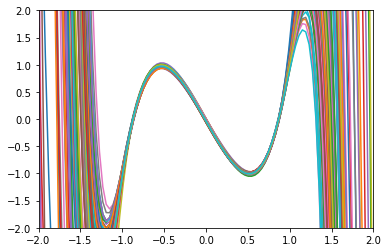

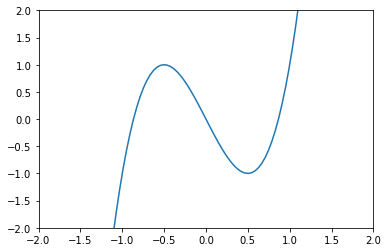

1.20400352872 15.1950247539
1.11110991074
BVD sum: 17.5101381933
Chi Square: 17.5101381933


In [8]:
N_law = 4
x_i = -1
x_f = 1
N_x=200
sigma = 0.1
noise_level = 1
N_model = 10

#define bounds to evaluate chi-squared
x_i_chi = 1
x_f_chi = 1.2
N_eval = 100

# determine the underlying law and data set data_eval to evaluate the chi-squared on
law_case_2 = Law(N_law)
N_replicas = 100
data_eval = Data(N_law, N_eval, x_i_chi, x_f_chi, noise_level, sigma, N_replicas)

data_case_2 = Data(N_law, N_x, x_i, x_f, noise_level, sigma, N_replicas)
model_case_2 = Model(N_model, data=data_case_2)
model_case_2.Numericfit(data_case_2, 4000, 0.00001, True)
coef_model = model_case_2.GN
bias_2, variance_2 = gen_bias_and_variance(coef_model, law_case_2, data_eval)
chi_square = chi_2(coef_model, data_eval)
level_1_noise = noise_lv1(coef_model, law_case_2, data_eval)

Plotsmoothpoly(model_case_2.GN)
Plotsmoothpoly(np.array([law_case_2.c]))
print(bias_2, variance_2)
print(level_1_noise)
print("BVD sum: " + str(bias_2 + variance_2 + level_1_noise))
print("Chi Square: " + str(chi_square))

### "Case 3": Bias-Variance Decomposition

Here we "combine" the above two cases so that the training sets are of the form $\mathcal{L} = \{ (y_{i}^{(l)}, x_{i}^{(l)}) \}.$ The training sets differ both in the range of data used to train the replica (choice of x-values as in case 2) and in the instance of the level-2 noise term (set of y-values as in case 1). 

After comparing the results of the three cases and looking at the BVD I am almost entirely certain that the discrepancy between the BVD sum and the directly computed chi-square is that in the BVD we take the average wrt the noise, which gets rid of some terms that we do not get rid of by simply averaging the chi-square of the replicas (i.e. simply taking $\mathbb{E}_{\mathcal{L}}$ instead of $\mathbb{E}_{\mathcal{L, \delta}}$). This is supported by the fact that in "Case 1" and "Case 3" the BVD and chi-squared are different, where in "Case 2" they are identical, indicating that the level-2 noise is responsible. This also makes sense as at no point do we perform the averaging over level-1 noise numerically in computing the average chi-squared, thus the terms that would be zero in the BVD expansion are non-zero.

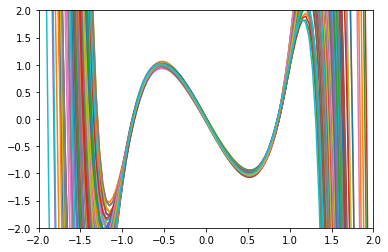

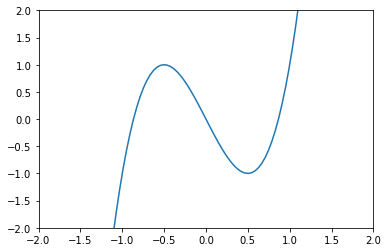

1.23344543753 17.5321648933
1.35850412011
BVD sum: 21.1241144509
Chi Square: 21.2413495864


In [9]:
N_law = 4
x_i = -1
x_f = 1
N_x=200
sigma = 0.1
noise_level = 2
N_model = 10

#define bounds to evaluate chi-squared
x_i_chi = 1
x_f_chi = 1.2
N_eval = 100

# determine the underlying law and data set data_eval to evaluate the chi-squared on
law_case_3 = Law(N_law)
N_replicas = 100
data_eval = Data(N_law, N_eval, x_i_chi, x_f_chi, noise_level, sigma, N_replicas)

data_case_3 = Data(N_law, N_x, x_i, x_f, noise_level, sigma, N_replicas)
model_case_3 = Model(N_model, data=data_case_3)
model_case_3.Numericfit(data_case_3, 4000, 0.00001, True)
coef_model = model_case_3.GN
bias_3, variance_3 = gen_bias_and_variance(coef_model, law_case_3, data_eval)
chi_square = chi_2(coef_model, data_eval)
level_1_noise = noise_lv1(coef_model, law_case_3, data_eval)

Plotsmoothpoly(model_case_3.GN)
Plotsmoothpoly(np.array([law_case_3.c]))
print(bias_3, variance_3)
print(level_1_noise)
print("BVD sum: " + str(1 + bias_3 + variance_3 + level_1_noise))
print("Chi Square: " + str(chi_square))

### Some remarks and open questions

It seems that in "Case 3" the chi-squared (and BVD sum) is lower than in "Case 1" and higher than in "Case 2". Does this make sense?

The BVD sum seems to be consistently _lower_ than the chi-squared which means that the level-2 noise terms are negative, is this reasonable?

On what set should we evaluate the bias and variance so that they are useful indicators of the performance of a model? I think that they will indicate the performance of the model on whichever set we decide to evaluate them on, so then we should choose these sets such that they are representative of the kinds of sets we would like our model to perform well on (?)

## Testing dependencies of Bias and Variance

Here we test the dependency of the variance with respect to the number of training points in a low bias-high variance model and see if increasing the number of training points decreases the variance substantially. We also see how they depend on the number of replicas (i.e. we wish to determine what is a sufficiently large number to be considered "infinite"). Related to this idea we also consider using regularized regression as a way of increasing bias, but reducing variance in an attempt to minimise the error further and obtain a better estimate of the underlying model. We will use the "Case 3" data generation method as it represents the most "realistic" data scenario. We will be using an overfit model (not sure what would be best to choose here, but an overfit model satisfies the above criteria in theory).

_Note to self:_ We also need to take into account and attempt to qauntify the reliability of the bias and variance measurements if they are going to inform the choice of model that we use.

### Bias and variance VS number of data points

In [10]:
N_law = 4
x_i = -1
x_f = 1
sigma = 0.1
noise_level = 2
N_model = 5
N_x_max = 500

#define bounds to evaluate chi-squared
x_i_chi = 1
x_f_chi = 1.2
N_eval = 100

# determine the underlying law and data set data_eval to evaluate the chi-squared on
law_case_3 = Law(N_law)
N_replicas = 100
data_eval = Data(N_law, N_eval, x_i_chi, x_f_chi, noise_level, sigma, N_replicas)


bias_plotting = []
variance_plotting = []
chi_square_plotting = []
level_1_noise_plotting = []
N_x_plotting = []
# for estimating how long it will take to run (assuming loops take same ammount of time)
t_i = time.time()
for N_x in range(10, N_x_max, 50):
    data_case_3 = Data(N_law, N_x, x_i, x_f, noise_level, sigma, N_replicas)
    model_case_3 = Model(N_model, data=data_case_3)
    model_case_3.Numericfit(data_case_3, 4000, 0.00001, True)
    coef_model = model_case_3.GN
    bias_3, variance_3 = gen_bias_and_variance(coef_model, law_case_3, data_eval)
    bias_plotting.append(bias_3)
    variance_plotting.append(variance_3)
    N_x_plotting.append(N_x)
    chi_square = chi_2(coef_model, data_eval)
    level_1_noise = noise_lv1(coef_model, law_case_3, data_eval)
    chi_square_plotting.append(chi_square)
    level_1_noise_plotting.append(level_1_noise)
    
    t_elapsed = time.time() - t_i
    t_total = (time.time() - t_i)*N_x_max/N_x
    print("Time elapsed: " + str(int(t_elapsed)) + "s")
    print("Total estimated runtime: " + str(int(t_total)) + "s")

Time elapsed: 0s
Total estimated runtime: 45s
Time elapsed: 2s
Total estimated runtime: 23s
Time elapsed: 5s
Total estimated runtime: 24s
Time elapsed: 8s
Total estimated runtime: 27s
Time elapsed: 13s
Total estimated runtime: 30s
Time elapsed: 17s
Total estimated runtime: 34s
Time elapsed: 23s
Total estimated runtime: 38s
Time elapsed: 30s
Total estimated runtime: 42s
Time elapsed: 37s
Total estimated runtime: 45s
Time elapsed: 46s
Total estimated runtime: 50s


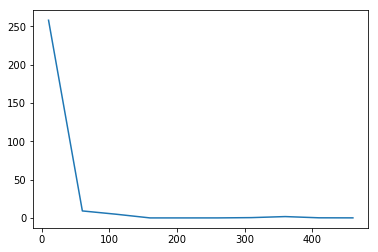

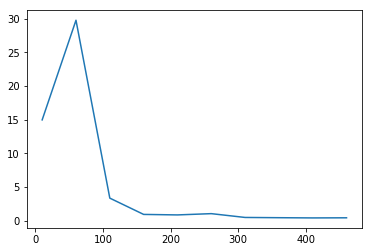

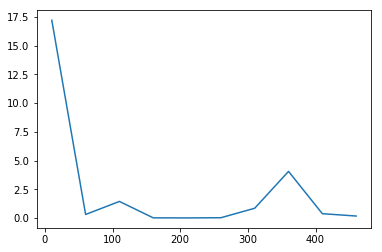

In [11]:
plt.figure()
plt.plot(N_x_plotting, bias_plotting)
plt.show()
plt.figure()
plt.plot(N_x_plotting, variance_plotting)
plt.show()
plt.figure()
plt.plot(N_x_plotting, list(np.array(bias_plotting)/np.array(variance_plotting)))
plt.show()

### Bias and Variance vs number of replicas

In [14]:
N_law = 4
x_i = -1
x_f = 1
N_x = 200
sigma = 0.1
noise_level = 2
N_model = 5
N_replicas_max = 400

#define bounds to evaluate chi-squared
x_i_chi = 1
x_f_chi = 1.2
N_eval = 100

# determine the underlying law
law_case_3 = Law(N_law)

bias_plotting = []
variance_plotting = []
chi_square_plotting = []
level_1_noise_plotting = []
N_replicas_plotting = []
# for estimating remaining time
t_i = time.time()
for N_replicas in range(10, N_replicas_max, 20):
    data_eval = Data(N_law, N_eval, x_i_chi, x_f_chi, noise_level, sigma, N_replicas)
    data_case_3 = Data(N_law, N_x, x_i, x_f, noise_level, sigma, N_replicas)
    model_case_3 = Model(N_model, data=data_case_3)
    model_case_3.Numericfit(data_case_3, 4000, 0.00001, True)
    coef_model = model_case_3.GN
    bias_3, variance_3 = gen_bias_and_variance(coef_model, law_case_3, data_eval)
    bias_plotting.append(bias_3)
    variance_plotting.append(variance_3)
    N_replicas_plotting.append(N_replicas)
    chi_square = chi_2(coef_model, data_eval)
    level_1_noise = noise_lv1(coef_model, law_case_3, data_eval)
    chi_square_plotting.append(chi_square)
    level_1_noise_plotting.append(level_1_noise)
    
    t_elapsed = time.time() - t_i
    t_total = (time.time() - t_i)*N_replicas_max/N_replicas
    print("Time elapsed: " + str(int(t_elapsed)) + "s")
    print("Total estimated runtime: " + str(int(t_total)) + "s")

Time elapsed: 0s
Total estimated runtime: 20s
Time elapsed: 1s
Total estimated runtime: 23s
Time elapsed: 3s
Total estimated runtime: 30s
Time elapsed: 6s
Total estimated runtime: 37s
Time elapsed: 10s
Total estimated runtime: 45s
Time elapsed: 14s
Total estimated runtime: 53s
Time elapsed: 19s
Total estimated runtime: 60s
Time elapsed: 25s
Total estimated runtime: 68s
Time elapsed: 32s
Total estimated runtime: 76s
Time elapsed: 40s
Total estimated runtime: 84s
Time elapsed: 48s
Total estimated runtime: 92s
Time elapsed: 57s
Total estimated runtime: 100s
Time elapsed: 67s
Total estimated runtime: 108s
Time elapsed: 78s
Total estimated runtime: 116s
Time elapsed: 90s
Total estimated runtime: 124s
Time elapsed: 102s
Total estimated runtime: 132s
Time elapsed: 115s
Total estimated runtime: 139s
Time elapsed: 129s
Total estimated runtime: 147s
Time elapsed: 143s
Total estimated runtime: 155s
Time elapsed: 159s
Total estimated runtime: 163s


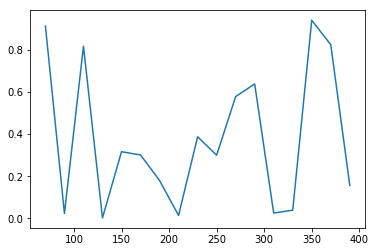

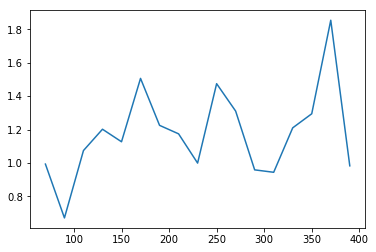

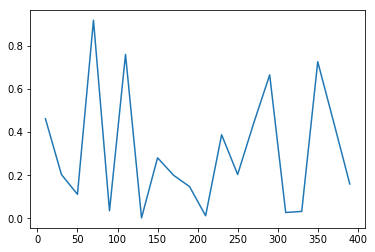

In [15]:
plt.figure()
plt.plot(N_replicas_plotting[3:], bias_plotting[3:])
plt.show()
plt.figure()
plt.plot(N_replicas_plotting[3:], variance_plotting[3:])
plt.show()
plt.figure()
plt.plot(N_replicas_plotting, list(np.array(bias_plotting)/np.array(variance_plotting)))
plt.show()

### Comparing the three cases

We now move on to compare the three cases, in an attempt to see where the largest sources of error lie. In "Case 1" the variance will be due solely to the differences in level-1 noise, as all of the models are trained on the same data set. In "Case 2" the variance will be due to the fact that the models are trained on different training sets, all with the same instance of level two noise. Finally in "Case 3" the variance will be due to both of these effects, and so we expect it to be, in general, higher than the other two. We will plot the error as a function of model complexity to see whether it alligns with what we expect form theory.

We will first perform these tests evaluating the bias, variance, noise and chi-square on the training set, then a validaiton set and finally on an extrapolation region.

In [ ]:
N_law_max = 11
x_i = -1
x_f = 1 
sigma = 0.1
N_model = 5
N_replicas = 100
N_x = 200

#lists for plotting
bias_list = [[],[],[]]
variance_list = [[],[],[]]
chi_square_list = [[],[],[]]
N_law_list = []

t_i = time.time()
for N_law in range(2, 11):
    law = Law(N_law)
    N_law_list.append(N_law)
  
   # "Case 1" BVD and chi-square
    noise_level = 2
    data_case_1 = Data(N_law, N_x, x_i, x_f, noise_level, sigma, N_replicas)
    model_case_1 = Model(N_model, data=data_case_1)
    model_case_1.Numericfit(data_case_1, 10000, 0.00001, False)
    coef_model_case_1 = model_case_1.GN
    
    bias_1, variance_1 = gen_bias_and_variance(coef_model_case_1, law, data_case_1)
    level_1_noise_1 = noise_lv1(coef_model_case_1, law, data_case_1)
    chi_square_1 = chi_2(coef_model_case_1, data_case_1)
    
    bias_list[0].append(bias_1)
    variance_list[0].append(variance_1)
    chi_square_list[0].append(chi_square_1)
    
    # "Case 2" BVD and chi-square
    noise_level = 1
    data_case_2 = Data(N_law, N_x, x_i, x_f, noise_level, sigma, N_replicas)
    model_case_2 = Model(N_model, data=data_case_2)
    model_case_2.Numericfit(data_case_2, 10000, 0.00001, True)
    coef_model_case_2 = model_case_2.GN
    
    bias_2, variance_2 = gen_bias_and_variance(coef_model_case_2, law, data_case_2)
    level_1_noise_2 = noise_lv1(coef_model_case_2, law, data_case_2)
    chi_square_2 = chi_2(coef_model_case_2, data_case_2)
    
    bias_list[1].append(bias_2)
    variance_list[1].append(variance_2)
    chi_square_list[1].append(chi_square_2)
    
    # "Case 3" BVD and chi-square
    noise_level = 2
    data_case_3 = Data(N_law, N_x, x_i, x_f, noise_level, sigma, N_replicas)
    model_case_3 = Model(N_model, data=data_case_3)
    model_case_3.Numericfit(data_case_3, 10000, 0.00001, True)
    coef_model_case_3 = model_case_3.GN
    
    bias_3, variance_3 = gen_bias_and_variance(coef_model_case_3, law, data_case_3)
    level_1_noise_3 = noise_lv1(coef_model_case_3, law, data_case_3)
    chi_square_3 = chi_2(coef_model_case_3, data_case_3)
    
    bias_list[2].append(bias_3)
    variance_list[2].append(variance_3)
    chi_square_list[2].append(chi_square_3)
    
    t_elapsed = time.time() - t_i
    t_total = (time.time() - t_i)*N_law_max/N_law
    print("Time elapsed: " + str(int(t_elapsed)) + "s")
    print("Total estimated runtime: " + str(int(t_total)) + "s")

Time elapsed: 30s
Total estimated runtime: 166s
Time elapsed: 60s
Total estimated runtime: 220s


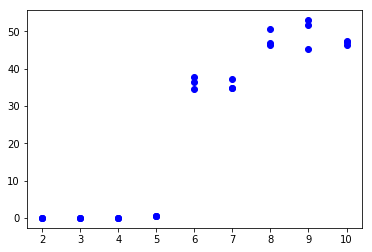

[[0.019907312930731901, 0.06848920503628543, 0.093343340246085607, 0.46648835486687995, 36.315616516351852, 37.318860360070936, 46.959809007167685, 52.971530293763053, 47.30934312748127], [0.025594476188772274, 0.020055539118348824, 0.052938283377307868, 0.4983952585946636, 37.654641807809575, 34.75557388023929, 50.538251083056345, 45.38462129417406, 46.291639561099593], [0.018144784700068025, 0.055437027879920053, 0.058126251155572455, 0.40680795139858966, 34.563206924248142, 34.80074668294322, 46.407415574821989, 51.613219429630021, 47.197192441336732]]


In [17]:
plt.figure()
for j in range(3):
    plt.plot(N_law_list, bias_list[j], 'bo')
plt.show()
print(bias_list)

## Appendix

### Variance proof

__Claim:__ In the case where the data sets $\mathcal{L} = \{(y_i^{(l)}, x_i)\}$ are different in only the y-value (i.e. in the value of the level-2 random noise) the variance is a constant, and is given by: $Var = \frac{1}{n}\mathrm{Tr}(Z_{\mathcal{L}}^T X^T X Z_{\mathcal{L}})$ where $X$ is the design matrix of data used to evaluate chi-squared and $ Z_{\mathcal{L}} = (X_{\mathcal{L}}^T X_{\mathcal{L}})^{-1} X_{\mathcal{L}}^T$ where $X_{\mathcal{L}}$ is the design matrix of data used to train the model. 

In the special case where $X_{\mathcal{L}} = X$ we get $Var = \frac{p}{n}$ where $p$ is the order of the model polynomial and $n$ the number of data points used to train the model.

__Proof:__

Consider the chi-squared expression we are minimising in order to determine the regression coefficients: $\mathbf{X}^2 = \sum_{i = 1}^{n} \frac{1}{n \sigma_i^2} (y_i - g_{\mathcal{L}}(x_i))^2.$ We can also express this in the matrix form $\mathbf{X}^2 = \frac{1}{n \sigma^2} (\mathbf{y} - X\mathbf{w})^T(\mathbf{y} - X\mathbf{w})$ where $X$ is the $n \times p$ design matrix of data we are evaluating chi-squared on. $n$ is the number of x-values and $p-1$ is the degree of our model, we also noted that the variance in the noise $\sigma^2$ is equal for all $y_i$. We then note that the elements of the vector $X \mathbf{w}$ are $g_{\mathcal{L}} = \mathbf{x}_i^T \mathbf{w}$ where $\mathbf{x}_i^T$ is the $i$th row of the design matrix and $\mathbf{w}$ is the vector of regression coefficients. We can now express the variance in this matrix formulation as:

$
Var = \frac{1}{n \sigma^2}\sum_{i = 1}^{n}\mathbb{E}_{\mathcal{L}}[(\mathbb{E}_{\mathcal{L}}[g_{\mathcal{L}}(x_i)] - g_{\mathcal{L}}(x_i))^2] = \frac{1}{n \sigma^2}\mathbb{E}_{\mathcal{L}}[(\mathbb{E}_{\mathcal{L}}[X\mathbf{w}] - X\mathbf{w})^T (\mathbb{E}_{\mathcal{L}}[X \mathbf{w}] - X \mathbf{w})]
$

Now $\mathbb{E}_{\mathcal{L}}[X \mathbf{w}] = 
\mathbb{E}_{\mathcal{L}}[X (X_{\mathcal{L}}^T X_{\mathcal{L}})^{-1}X_{\mathcal{L}}^T \mathbf{y}] = 
\mathbb{E}_{\mathcal{L}}[H_{\mathcal{L}} (\mathbf{y}_0 + \mathbf{\delta})] = 
H_{\mathcal{L}} \mathbf{y}_0 + H_{\mathcal{L}} \mathbb{E}_{\mathcal{L}}[\mathbf{\delta}] = 
H_{\mathcal{L}} \mathbf{y}_0$

Where we used the fact that the solution to the linear regression problem of minimizing the chi-square (here simply a scaled version of the least-squares error) is $\mathbf{w} = (X_{\mathcal{L}}^T X_{\mathcal{L}})^{-1}X_{\mathcal{L}}^T \mathbf{y}$. We also recognized $H = X (X^T X)^{-1}X^T$ as the "hat matrix" (very important in linear regression analysis) (Montgomery et al.) however we noted that in our case, because the design matrix in the expression for the coefficients $X_{\mathcal{L}}$ is, in general, different to the one ($X$) used in evaluating chi-squared it is a slightly different quantity than the canonical hat matrix and so we denote it $H_{\mathcal{L}}$. We recognize that in this case where all of the replicas are trained on the same set of x-values, then the design matrix $X_{\mathcal{L}}$ is a constant across different training instances. We also noted that the vector $\mathbf{y}_0$ of values generated by the underlying law is also constant, and so the only term affected by the averaging process is the vector of level-2 noise $\mathbf{\delta}$, which has $\mathbb{E}_{\mathcal{L}}[\mathbf{\delta}] = 0$ and variance $\sigma^2$. We also note that the noise variables are uncorrelated, that is $\mathbb{E}_{\mathcal{L}}[\delta_i \delta_j] = 0$ for $i \neq j.$

We can now compute the variance using this notation:

$
Var = \frac{1}{n \sigma^2}\mathbb{E}_{\mathcal{L}}[(H_{\mathcal{L}} \mathbf{y}_0 - (H_{\mathcal{L}} \mathbf{y}_0 + H_{\mathcal{L}} \mathbf{\delta}))^T (H_{\mathcal{L}} \mathbf{y}_0 - (H_{\mathcal{L}} \mathbf{y}_0 + H_{\mathcal{L}} \mathbf{\delta}))] 
= \frac{1}{n \sigma^2}\mathbb{E}_{\mathcal{L}}[(H_{\mathcal{L}} \mathbf{\delta})^T(H_{\mathcal{L}} \mathbf{\delta})] 
= \frac{1}{n \sigma^2}\mathbb{E}_{\mathcal{L}}[\mathbf{\delta}^T H_{\mathcal{L}}^T H_{\mathcal{L}} \mathbf{\delta}] 
$

$
= \frac{1}{n \sigma^2}\mathbb{E}_{\mathcal{L}}[\sum_{i=1}^{n}\sum_{j=1}^{n} \delta_{i}[H_{\mathcal{L}}^T H_{\mathcal{L}}]_{ij}\delta_{j}]
= \frac{1}{n \sigma^2}\sum_{i=1}^{n}\sum_{j=1}^{n} [H_{\mathcal{L}}^T H_{\mathcal{L}}]_{ij}\mathbb{E}_{\mathcal{L}}[\delta_{i}\delta_{j}]
= \frac{1}{n \sigma^2}\sum_{i=1}^{n} [H_{\mathcal{L}}^T H_{\mathcal{L}}]_{ii} \sigma^2
= \frac{1}{n} \mathrm{Tr}(H_{\mathcal{L}}^T H_{\mathcal{L}}) = \frac{1}{n} \mathrm{Tr}(Z_{\mathcal{L}}^T X^T X Z_{\mathcal{L}})
$

Where we defined $Z_{\mathcal{L}}^T =(X_{\mathcal{L}}^T X_{\mathcal{L}})^{-1} X_{\mathcal{L}}^T.$

Finally, we note that in the special case where $X_{\mathcal{L}} = X$ (and so $H_{\mathcal{L}} = H$) we get that 

$Var = \frac{1}{n} \mathrm{Tr}(H_{\mathcal{L}}^T H_{\mathcal{L}}) = \frac{1}{n} \mathrm{Tr}(H) = \frac{1}{n} \mathrm{Tr}( X(X^T X)^{-1}X^T) = \frac{1}{n} \mathrm{Tr}(I_p) = \frac{p}{n}$

where we used the fact that $H^T = H$, $H^2 = X(X^T X)^{-1}X^T X(X^T X)^{-1}X^T = H$ and $\mathrm{Tr}(A B^T) = \mathrm{Tr}(B^T A).$

### Bias Proof

__Claim:__ The bias in the case where the data sets $\mathcal{L} = \{(y_i^{(l)}, x_i)\}$ are different in only the y-value (i.e. in the value of the level-2 random noise) is given by $Bias^2 = \frac{1}{n \sigma^2}(\mathbf{y}_0^T\mathbf{y}_0 - \mathbf{y}_{0, \mathcal{L}}^T Z_{\mathcal{L}}^T X^T \mathbf{y}_0 - \mathbf{y}_0^T X Z_{\mathcal{L}} \mathbf{y}_{0, \mathcal{L}} - \mathbf{y}_{0, \mathcal{L}}^T Z_{\mathcal{L}}^T X^T X Z_{\mathcal{L}} \mathbf{y}_{0, \mathcal{L}})$. 

In the special case where the data used to train the models is the same as the data used to evaluate the chi-squared we have that $ Bias^2 = \frac{1}{n \sigma^2} \mathbf{y}_0^T(I - H)\mathbf{y}_0.$

__Proof:__ 

The definition of bias we normally use, and that given in the review is 

$Bias^2 = \frac{1}{n \sigma^2} \sum_{i=1}^{n} (f(x_i) - \mathbb{E}_{\mathcal{L}}[g_{\mathcal{L}}(x_i)])^2$

We now re-express this in matrix formulation, with the definitions identical to those in the previous proof, and simplify:


$Bias^2 = \frac{1}{n \sigma^2} (\mathbf{y}_0 - \mathbb{E}_{\mathcal{L}}[X \mathbf{w}])^T(\mathbf{y}_0 - \mathbb{E}_{\mathcal{L}}[X \mathbf{w}]) 
= \frac{1}{n \sigma^2} (\mathbf{y}_0 - \mathbb{E}_{\mathcal{L}}[H \mathbf{y}])^T(\mathbf{y}_0 - \mathbb{E}_{\mathcal{L}}[H \mathbf{y}]) 
= \frac{1}{n \sigma^2} (\mathbf{y}_0 - \mathbb{E}_{\mathcal{L}}[H (\mathbf{y}_{0, \mathcal{L}} + \mathbf{\delta})])^T (\mathbf{y}_0 - \mathbb{E}_{\mathcal{L}}[H (\mathbf{y}_{0, \mathcal{L}} + \mathbf{\delta})])$

Here we use the result above that $\mathbb{E}_{\mathcal{L}}[H_{\mathcal{L}} (\mathbf{y}_0 + \mathbf{\delta})] = H_{\mathcal{L}} \mathbf{y}_0$ and $\mathbb{E}_{\mathcal{L}}[H_{\mathcal{L}} (\mathbf{y}_{0, \mathcal{L}} + \mathbf{\delta})] = H_{\mathcal{L}} \mathbf{y}_{0, \mathcal{L}}$ so we find:

$Bias^2 = \frac{1}{n \sigma^2}(\mathbf{y}_0^T\mathbf{y}_0 - \mathbf{y}_{0, \mathcal{L}}^T Z_{\mathcal{L}}^T X^T \mathbf{y}_0 - \mathbf{y}_0^T X Z_{\mathcal{L}} \mathbf{y}_{0, \mathcal{L}} + \mathbf{y}_{0, \mathcal{L}}^T Z_{\mathcal{L}}^T X^T X Z_{\mathcal{L}} \mathbf{y}_{0, \mathcal{L}})$

In the special case where the training data is the same as the data we evaluate chi-squared on we have $X Z_{\mathcal{L}} = H$ and so

$Bias^2 = \frac{1}{n \sigma^2} (\mathbf{y}_0 - H \mathbf{y}_0)^T (\mathbf{y}_0 - H \mathbf{y}_0)
= \frac{1}{n \sigma^2} (\mathbf{y}_0^T \mathbf{y}_0 - \mathbf{y}_0^T H^T \mathbf{y}_0 - \mathbf{y}_0^T H \mathbf{y}_0 + \mathbf{y}_0^T H^T H \mathbf{y}_0) 
= \frac{1}{n \sigma^2} (\mathbf{y}_0^T \mathbf{y}_0 - \mathbf{y}_0^T H \mathbf{y}_0) 
= \frac{1}{n \sigma^2} \mathbf{y}_0^T(I - H)\mathbf{y}_0$ 

where we used the fact that $H^T = H$ and $H^2 = X(X^T X)^{-1}X^T X(X^T X)^{-1}X^T = H$

## References

Montgomery, Peck and Vining. "Introduction to Linear Regression Analysis (5th ed.)". New Jersey: John Wiley & Sons Inc., 2012. Print. 